# How to get age predictions from rows of Gaia data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import age_prediction_tool as lf
import pickle

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10, 6]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Query Gaia

Get Gaia data for the stars you're interested in

In [7]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

In [8]:
# Do your Gaia query or input a table of Gaia data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

coord = SkyCoord(ra=280, dec=60, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(5, u.deg)
height = u.Quantity(5, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

# Filtering out stars without radial velocity
r = r[~r['radial_velocity'].mask]

#r.pprint(max_lines=12, max_width=130)

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
r

dist,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
float64,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,fl

# Calculate Jz

You need to calculate ln(Jz) (log of vertical action) for each Gaia star. The star must have a radial velocity.

For some reason (I don't know why yet) you have to input a table with at least two rows. It doesn't work if you just input one row of Gaia data. Working on fixing it

In [10]:
# This function returns a table with three new 
# columns for the action angles at the end: Jz, Jphi, and Jtheta

# This line will take a while for large tables. maybe an hour for 1E5s of stars

r_actions = lf.calc_jz(r)
r_actions

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


dist,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Jz,Jphi,Jtheta
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,km kpc / s,km kpc / s,km kpc / s
float64,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,fl

# Age-Jz Relation Calibrated on RGB ages

This is my pre-calibrated age-Jz relation calibrated on stellar ages.

It's on Zenodo at: 10.5281/zenodo.10048927

In [13]:
spline_direct = "../../RGB_spline_model/"

RGB_spline = lf.read(directory=spline_direct)

In [14]:
# this function evaluates age predictions for a set of ln(Jz) values.

eval_grid, starRGB_eval_pdf = RGB_spline.evaluate_ages(np.log(r_actions['Jz']), eval_grid=np.linspace(0, 14, 1000))

100%|██████████| 2/2 [00:00<00:00, 158.79it/s]


Text(0.5, 1.0, 'lnJz = 1.2102265696947772')

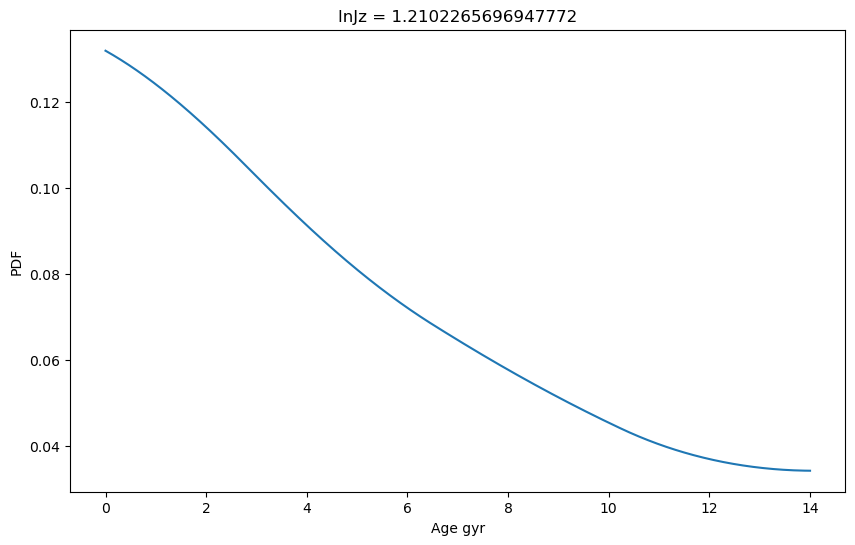

In [15]:
# You will probably only be interested in eval_grid and the eval_pdf variable. 
# This is the age prediction for the first star in our Gaia table

plt.plot(eval_grid, starRGB_eval_pdf[0])

plt.xlabel('Age gyr')
plt.ylabel('PDF')
plt.title('lnJz = ' + str((np.log(r_actions['Jz'][0]))))

Text(0.5, 1.0, 'lnJz = 3.913578297732017')

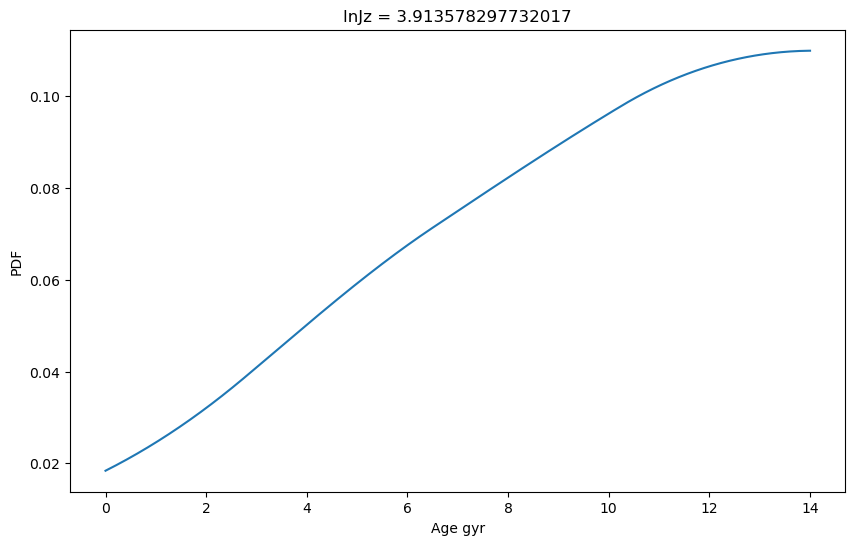

In [16]:
# this is the age prediction for the second star in the table

plt.plot(eval_grid, starRGB_eval_pdf[1])

plt.xlabel('Age gyr')
plt.ylabel('PDF')

plt.title('lnJz = ' + str((np.log(r_actions['Jz'][1]))))

# Age-Jz Relation Calibrated on MSTO ages

Pre-calibrated spline model on MSTO stars.

In [17]:
spline_direct = "../../MSTO_spline_model/"

MSTO_spline = lf.read(directory=spline_direct)

In [18]:
# this function evaluates age predictions for a set of ln(Jz) values.

eval_grid, starMSTO_eval_pdf = MSTO_spline.evaluate_ages(np.log(r_actions['Jz']), eval_grid=np.linspace(0, 14, 1000))

100%|██████████| 2/2 [00:00<00:00, 1084.64it/s]


Text(0.5, 1.0, 'lnJz = 1.2102265696947772')

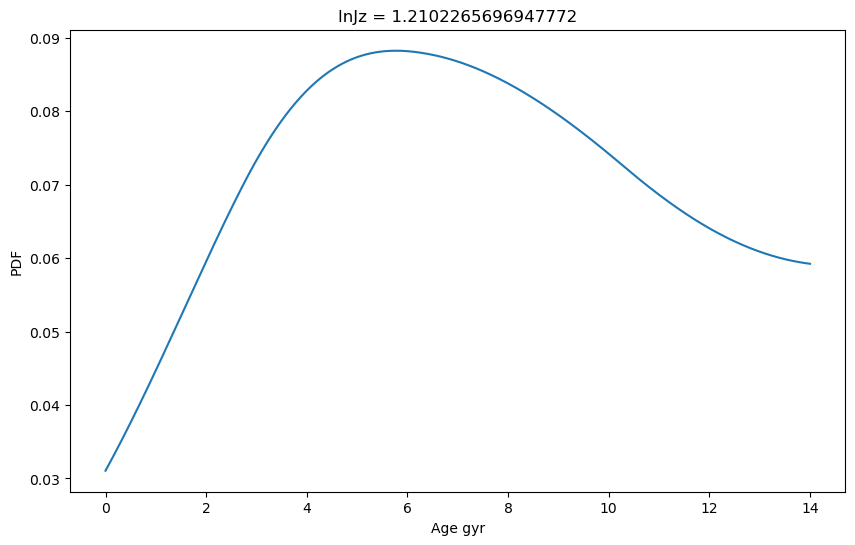

In [19]:
# You will probably only be interested in eval_grid and the eval_pdf variable. 
# this is the age prediction for the first star in our Gaia table

plt.plot(eval_grid, starMSTO_eval_pdf[0])

plt.xlabel('Age gyr')
plt.ylabel('PDF')
plt.title('lnJz = ' + str((np.log(r_actions['Jz'][0]))))

Text(0.5, 1.0, 'lnJz = 3.913578297732017')

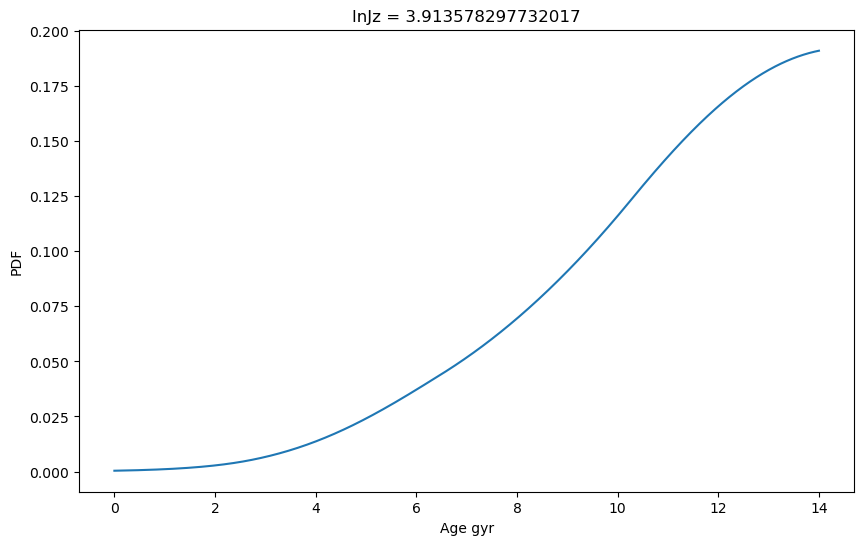

In [20]:
# this is the age prediction for the second star in the table

plt.plot(eval_grid, starMSTO_eval_pdf[1])

plt.xlabel('Age gyr')
plt.ylabel('PDF')

plt.title('lnJz = ' + str((np.log(r_actions['Jz'][1]))))